![Сбор данных](https://ptzgovorit.ru/sites/default/files/original_nodes/banka_tasima_7.jpg)

# Содержание

- [1. Библиотеки](#1.-Библиотеки)
- [2. Загрузка и предобработка временного ряда](#2.-Загрузка-и-предобработка-временного-ряда)
- [3. Визуальный анализ ряда](#3.-Визуальный-анализ-ряда)
- [4. Декомпозиция и анализ Фурье](#4.-Декомпозиция-и-анализ-Фурье)
- [5. Выводы](#5.-Выводы)

# 1. Библиотеки

In [1]:
%matplotlib inline

#базовые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import datetime

#библиотеки для анаоиза временного ряда остатков на счетах клиентов:
#декомпозиция, фурье, тест на стационарность
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
import statsmodels.api as sm # отсюда будем брать тест Дикки-Фуллера

#для отладки кода (в случае необходимости)
import pdb

[Вверх к содержанию](#Содержание)

# 2. Загрузка и предобработка временного ряда

In [2]:
#загружаем данные в датафрейм и посмотрим на них
sb = pd.read_csv('C:/Users/Алексей Третьяков/Desktop/ML_projects/FierceDra-X.github.io/Sber/data.csv', sep = ';')
sb.sample(5)

,REPORTDATE,VALUE
1525,04.03.2018,43686619417
856,04.05.2016,21048581591
71,11.03.2014,4908867532
830,08.04.2016,21634683280
2043,04.08.2019,65169936729


In [3]:
#посмотрим на сводку информации о датафрейме и проверим наличие пустых значений
sb.info(), sb.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   REPORTDATE  2111 non-null   object
 1   VALUE       2111 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 33.1+ KB


(None,
 REPORTDATE    0
 VALUE         0
 dtype: int64)

В ряде нет нулевых значений; значения дат находятся в строковом формате; value имеют визуально неудобную длину;

Переименуем столбцы в более удобные значения date и value; переменную date переведем в формат datetime; value разделим на 10 в шестой степени и округлим до одного знака

In [4]:
new_columns = ['date', 'value']
sb.columns = new_columns

sb['date'] = pd.to_datetime(sb['date'], format = '%d.%m.%Y')
sb['value'] = np.round(sb.value.values/10**6, 1)

In [7]:
sb.sample(5)

,date,value
471,2015-04-15,15875.4
1502,2018-02-09,49680.2
1167,2017-03-11,35074.2
41,2014-02-09,4331.9
112,2014-04-21,4320.1


[Вверх к содержанию](#Содержание)

# 3. Визуальный анализ ряда

в этом разделе визуально посмотрим на ряд с целью первичного выявления его характеристик

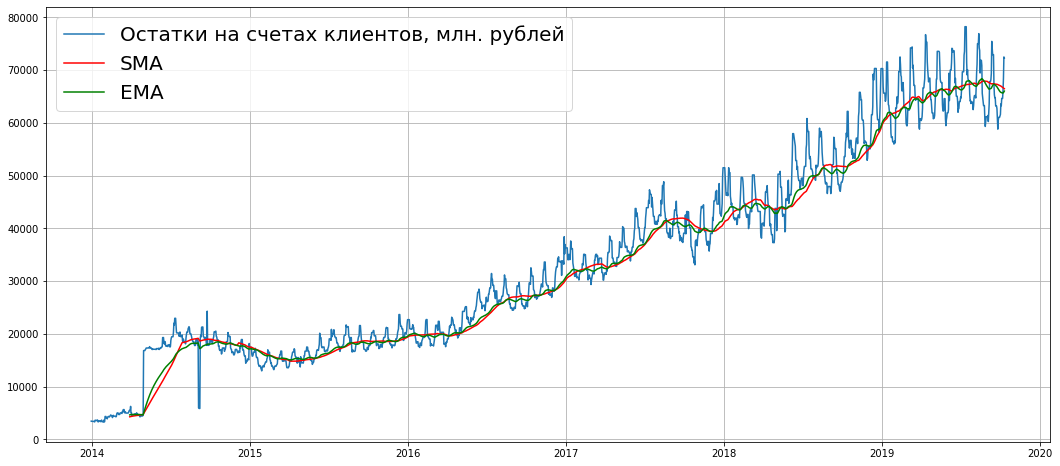

In [8]:
## визуализируем ряд вместе со скользящими средними (обычное и экспоненциальное) ряда с окном в 3 месяца
N=90
sb['rolling_min_sma'] = sb.value.rolling(window=N).mean()
sb['rolling_min_ema'] = sb.value.ewm(min_periods=N, span=N).mean()


f, ax = plt.subplots(1, 1, figsize=(18, 8))

ax.plot(sb.date, sb.value)
ax.plot(sb.date, sb.rolling_min_sma, c='r')
ax.plot(sb.date, sb.rolling_min_ema, c='g')
ax.legend(['Остатки на счетах клиентов, млн. рублей', 'SMA', 'EMA'], fontsize=20)
ax.grid()

> * ряд имеет явный тренд роста с  середины 2015 года и, скорее всего, его первые разницы на тренде стационарны
> * еще видны регулярные колебания, посмотрим на них в более коротких отрезках времени

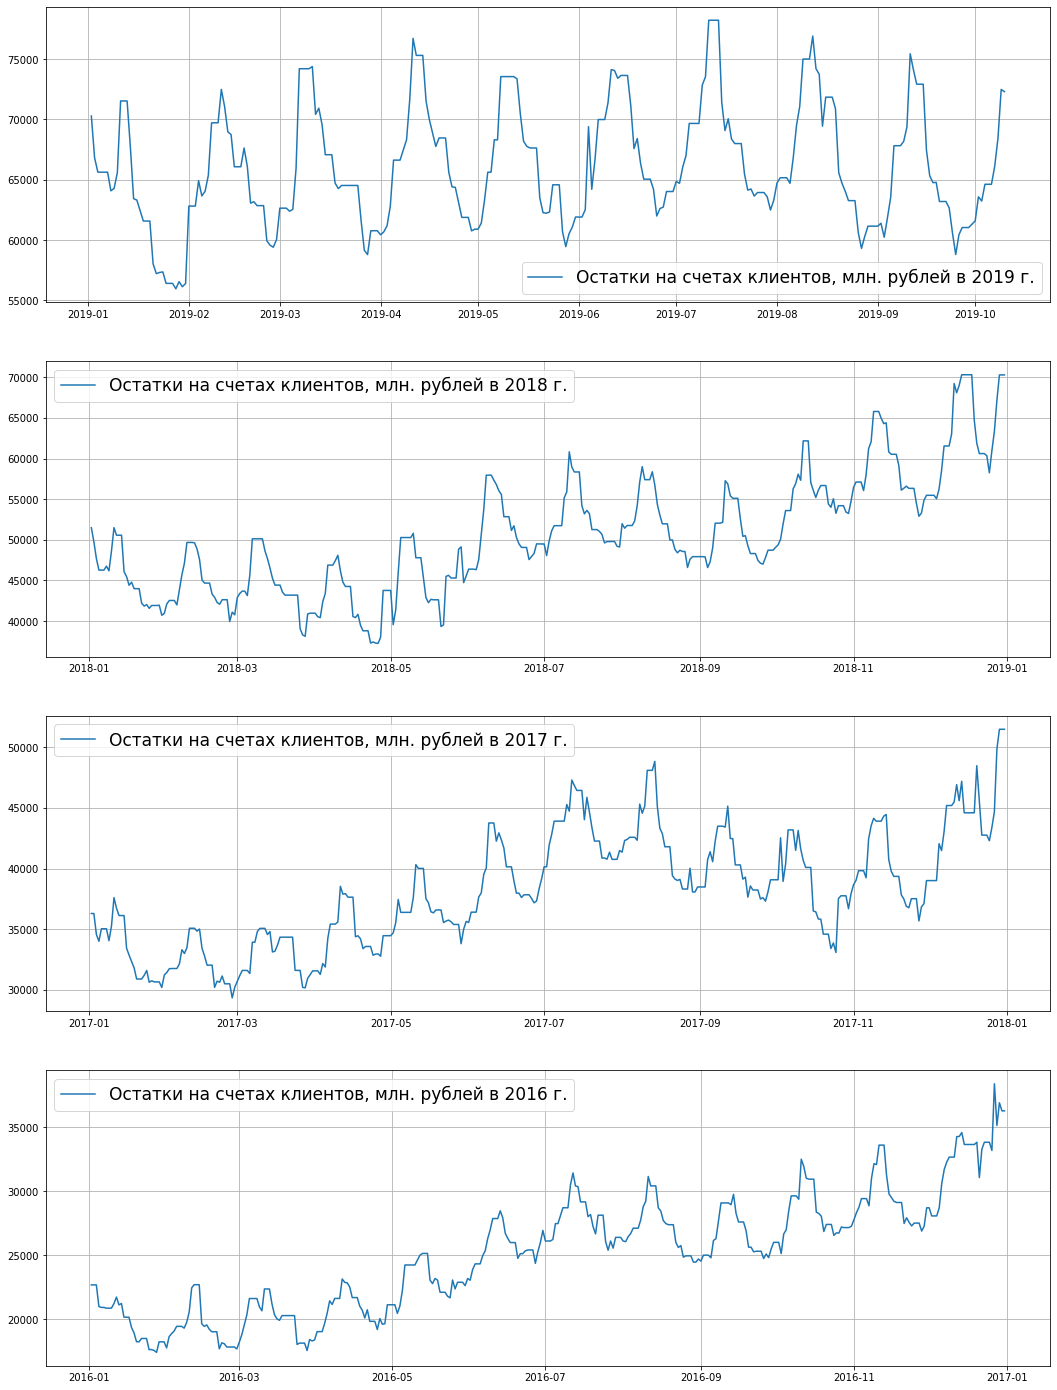

In [9]:
f, ax = plt.subplots(4, 1, figsize=(18, 25))

ax[0].plot(sb[sb.date > '2019-01-01'].date, sb[sb.date > '2019-01-01'].value) 
ax[0].legend(['Остатки на счетах клиентов, млн. рублей в 2019 г.'], fontsize=17)
ax[0].grid()

ax[1].plot(sb[(sb.date > '2018-01-01') & (sb.date < '2019-01-01')].date,
           sb[(sb.date > '2018-01-01') & (sb.date < '2019-01-01')].value) 
ax[1].legend(['Остатки на счетах клиентов, млн. рублей в 2018 г.'], fontsize=17)
ax[1].grid()

ax[2].plot(sb[(sb.date > '2017-01-01') & (sb.date < '2018-01-01')].date,
           sb[(sb.date > '2017-01-01') & (sb.date < '2018-01-01')].value) 
ax[2].legend(['Остатки на счетах клиентов, млн. рублей в 2017 г.'], fontsize=17)
ax[2].grid()

ax[3].plot(sb[(sb.date > '2016-01-01') & (sb.date < '2017-01-01')].date,
           sb[(sb.date > '2016-01-01') & (sb.date < '2017-01-01')].value) 
ax[3].legend(['Остатки на счетах клиентов, млн. рублей в 2016 г.'], fontsize=17)
ax[3].grid()

> * остатки явно испытывают месячные колебания
> * минимумы приходятся на конец месяца, максимумы на район 10-ого числа месяца
> * скорее всего, это влияние цикличности в выплатах заработной платы
> * также видно, что остатки не росли в первые 5 месяцев в 2016-2018 годах, рост начинался примерно после мая

[Вверх к содержанию](#Содержание)

# 4. Декомпозиция и анализ Фурье

In [11]:
# разложим ряд на трендовую, сезонную и шумовую составляющие
#для этого колонку дат переведем в индексную колонку
sb_decomp = sb.set_index(pd.DatetimeIndex(sb['date']))

#оставим только колонку value, остальные удалим
sb_decomp.drop(['date','rolling_min_sma','rolling_min_ema'], axis = 1, inplace=True)

#создадим экземпляр декомпозиции
decomposition = seasonal_decompose(sb_decomp, model='additive') 

trend_part = decomposition.trend #вычислим трендовую составляющую
seasonal_part = decomposition.seasonal #вычислим сезонную составляющую
residual_part = decomposition.resid # отдельно шум: то, что осталось

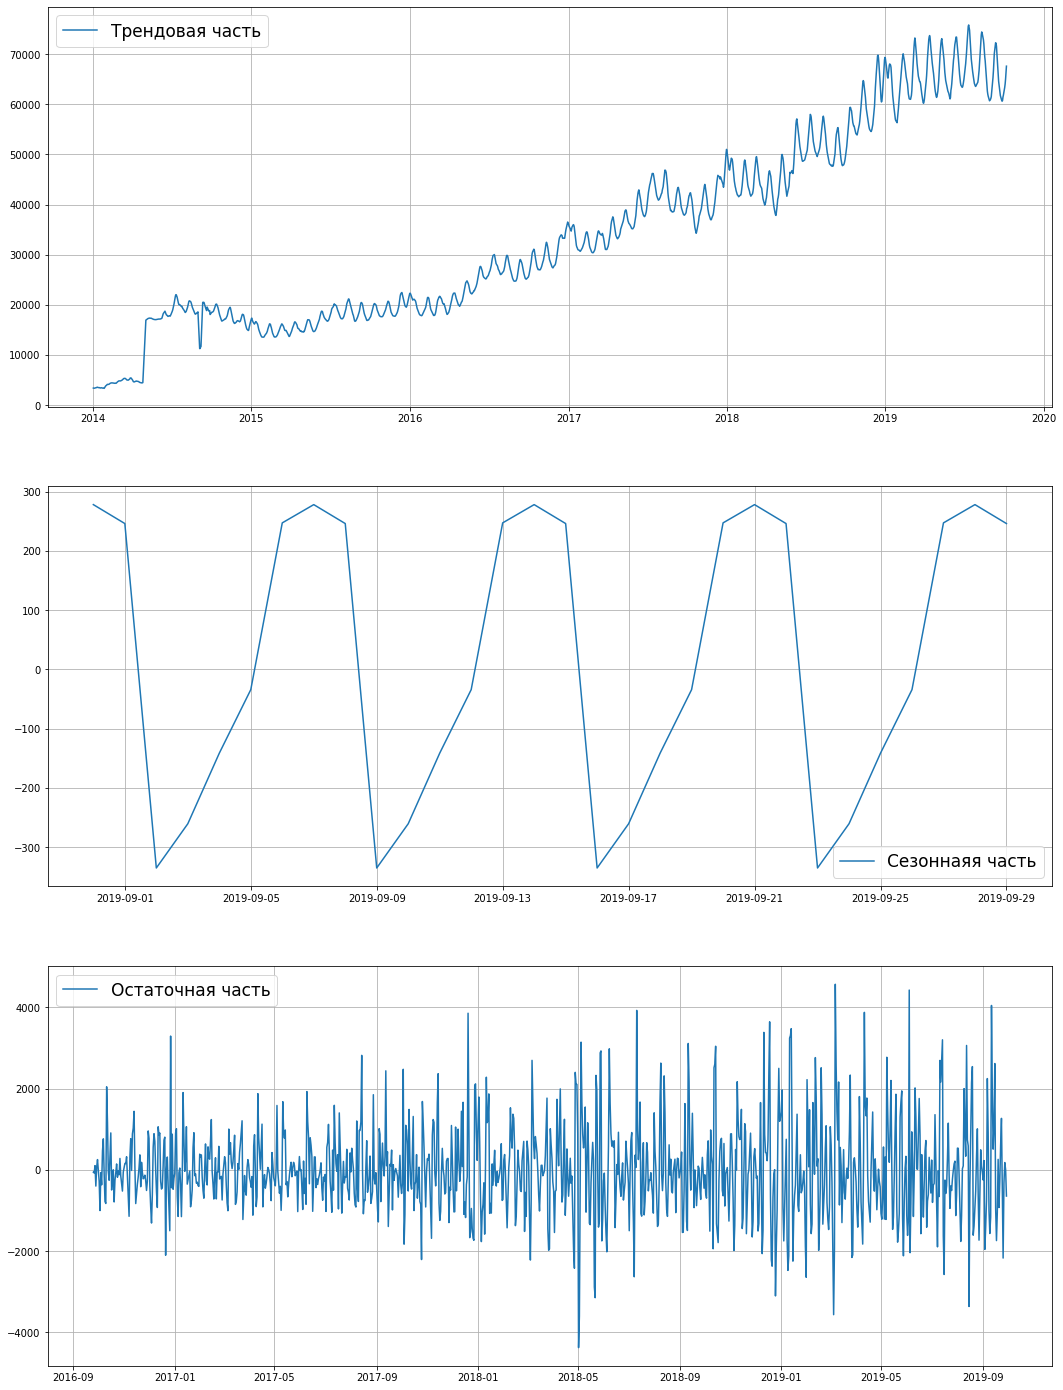

In [14]:
## визуализируем все три части
f, ax = plt.subplots(3, 1, figsize=(18, 25))

ax[0].plot(trend_part) 
ax[0].legend(['Трендовая часть'], fontsize=17)
ax[0].grid()

ax[1].plot(seasonal_part[2070:2100]) 
ax[1].legend(['Сезоннаяя часть'], fontsize=17)
ax[1].grid()

ax[2].plot(residual_part[1000:2100]) 
ax[2].legend(['Остаточная часть'], fontsize=17)
ax[2].grid()

> * сезонная часть есть, она имеет примерно недельный период (возможно в выходные люди снимают часть денег со счетов в связи с выходными тратами), но она незначительна в амплитуде, размах не более 300 млн. руб.
> * ряд в основном состоит из трендовой и остаточной случайной части с амплитудами колебаний в 2-4 млрд. руб.
> * случайная часть увеличивает стандартное отклонение ближе к 2019 году

Дальше попробуем проверить первые разности ряда на стационарность.

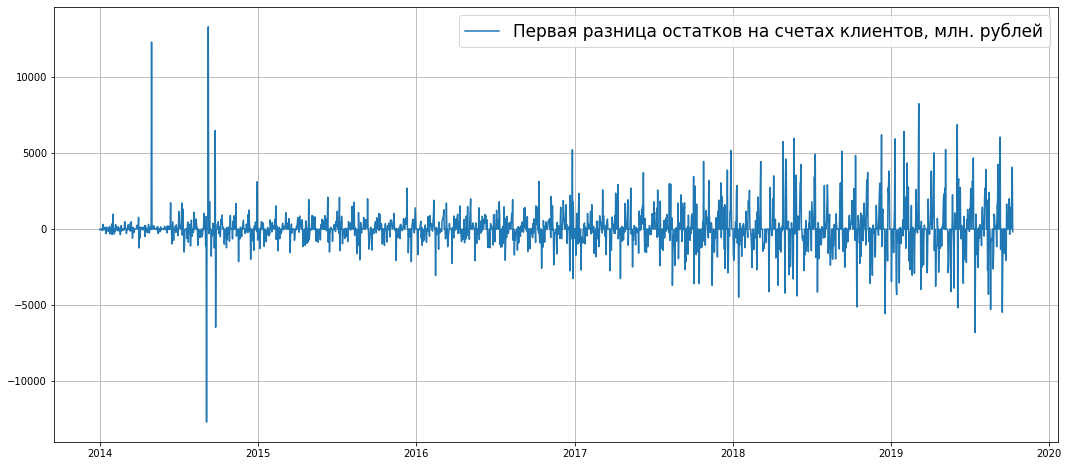

In [18]:
#создадим колонку с первыми разностями и построим их график
sb['res'] =  sb.value - sb.value.shift(1)

f, ax = plt.subplots(1, 1, figsize=(18, 8))

ax.plot(sb.date, sb.res)
ax.legend(['Первая разница остатков на счетах клиентов, млн. рублей'], fontsize=17)
ax.grid()

In [21]:
#посмотрим среднее значение ряда и его стандартное отклонение
np.round(sb['res'].mean()), np.round(sb['res'].std())

(33.0, 1280.0)

Визуально ряд первых разниц вроде стационарен, среднее значение практчески нулевое, но проверим его тестом Дикки-Фуллера

In [22]:
# тест Дикки-Фуллера
test = sm.tsa.adfuller(sb['res'][1:].values)
p_value = test[1]
print ('p-value: ', p_value)
if p_value> 0.05: 
    print (' ряд не стационарен')
else:
    print ('ряд стационарен')

p-value:  0.0
ряд стационарен


В итоге первые разности ряда стационарны, можно попробовать построить модель ARIMA. Для этого посмотрим автокорреляции в ряде:

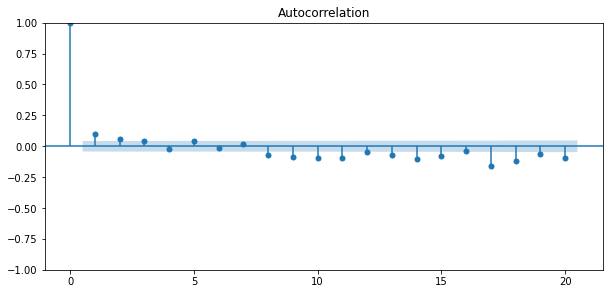

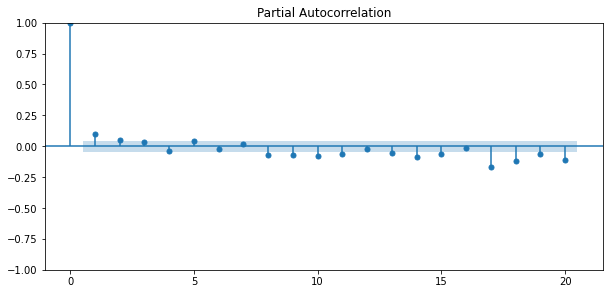

In [13]:
#построим график автокоррелляций первых разниц
f, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(2,1,1)
sm.graphics.tsa.plot_acf(sb.res.values[1:].squeeze(), lags=20, ax=ax)
plt.show()

#построим график частичной автокоррелляции первых разниц
f, ax = plt.subplots(figsize=(10, 10))
ax = plt.subplot(2,1,2)
sm.graphics.tsa.plot_pacf(sb.res.values[1:].squeeze(), lags=20, method = 'ywm', ax=ax)
plt.show()

На обоих графиках видно, что ряд первых разниц коррелирует только сам с собой, то есть, если строить модель ARIMA, то с первой разницей и случайноу частью.

Посмотрим на фурье распределение сезонной и остаточной части ряда value (трендовую часть не будем смотреть, у нее будет одна главная низкая частота)

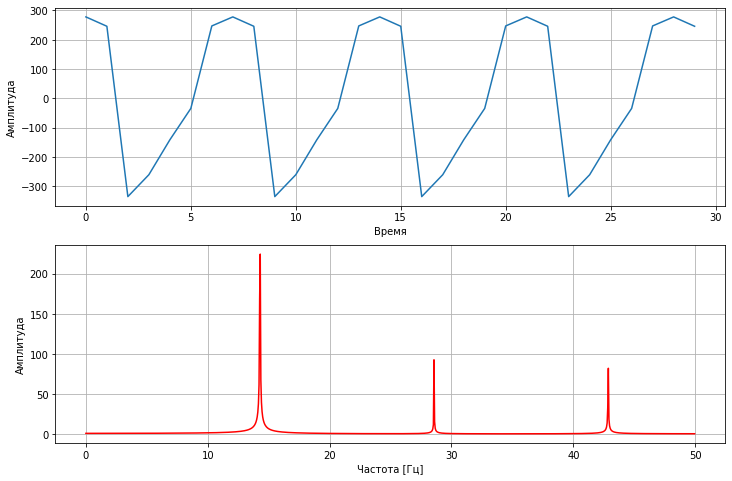

In [40]:
#фурье сезонной части

Fs = 100## частота дискретизации: 100 Гц
Ts = 1/Fs ## интервал времени между соседними точками

N = len(seasonal_part[3:2009].values)
## создаём сетку частот
frq = np.fft.fftfreq(N, Ts)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
frq = frq[range(int(N/2))]

## делаем преобразование Фурье
Y = 2/N * np.fft.fft(seasonal_part[3:2009].values)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
Y = Y[range(int(N/2))]

## визуализируем
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(seasonal_part[2000:2030].values)
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Амплитуда')
ax[0].grid()

ax[1].plot(frq, abs(Y), 'r') 
ax[1].set_xlabel('Частота [Гц]')
ax[1].set_ylabel('Амплитуда')
ax[1].grid()

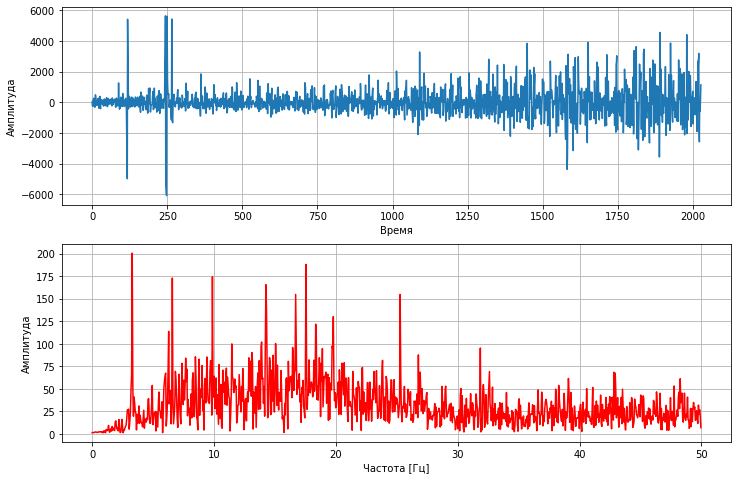

In [41]:
#фурье остаточной части

Fs = 100## частота дискретизации: 100 Гц
Ts = 1/Fs ## интервал времени между соседними точками

N = len(residual_part[3:2009].values)
## создаём сетку частот
frq = np.fft.fftfreq(N, Ts)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
frq = frq[range(int(N/2))]

## делаем преобразование Фурье
Y = 2/N * np.fft.fft(residual_part[3:2009].values)
## нас интересуют только положительные частоты (отрицательные частоты симметричны) 
Y = Y[range(int(N/2))]

## визуализируем
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(residual_part[3:2030].values)
ax[0].set_xlabel('Время')
ax[0].set_ylabel('Амплитуда')
ax[0].grid()

ax[1].plot(frq, abs(Y), 'r') 
ax[1].set_xlabel('Частота [Гц]')
ax[1].set_ylabel('Амплитуда')
ax[1].grid()

дляс целей построения модели попробуем очистить ряд value от частот сезонной составляющей и основной части высоких частот шума

In [43]:
## создаём фильтр Баттерворта
b, a = signal.butter(8, 0.1)
## и применяем его
value_filt = signal.filtfilt(b, a, sb.value, padlen=150)

In [46]:
#добавим фильтрованные значения в наш исходный дата фрейм и удалим ненужные скользящие средние
sb['value_filt'] = value_filt
sb.drop(['rolling_min_sma','rolling_min_ema'], axis=1, inplace=True)

KeyError: "['rolling_min_sma' 'rolling_min_ema'] not found in axis"

In [48]:
sb.sample(5) #остались только колонки, которые нам потом потребуются в построении моделей

,date,value,res,value_filt
2018,2019-07-10,73549.0,704.7,74175.788370
140,2014-05-19,17125.8,-186.8,16784.760111
1824,2018-12-28,67151.5,3814.0,64167.680023
574,2015-07-27,16817.7,-822.2,17107.424302
2080,2019-09-10,69394.1,1205.7,70669.706633


Так как в течение месяца остатки испытывают колебания, имея минимум, сделаем второй дата фремй с undersampled  данными. Снижение размерности ряда сделаем по минимуму в каждом месяце для value и value_filt, а для ряда первых разностей res сделаем их сумму за месяц.

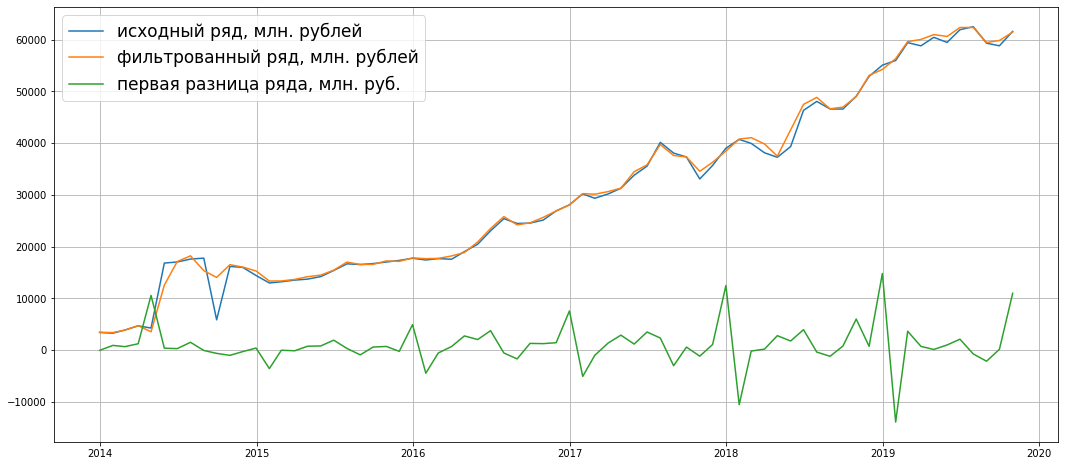

In [49]:
#словарь конверсии данных
conversion = {'value' : 'min',
             'value_filt': 'min',
             'res': 'sum'}

sb = sb.set_index('date')
sb_resampled = sb[1:].resample('1M').apply(conversion) #применяем конверсию в каждом периоде размера 1 месяц
sb = sb.reset_index()
sb_resampled = sb_resampled.reset_index()


#нарисуем undersampled ряды value, value_filt, res:
f, ax = plt.subplots(1, 1, figsize=(18, 8))

ax.plot(sb_resampled.date, sb_resampled.value)
ax.plot(sb_resampled.date, sb_resampled.value_filt)
ax.plot(sb_resampled.date, sb_resampled.res)
ax.legend(['исходный ряд, млн. рублей', 'фильтрованный ряд, млн. рублей', 'первая разница ряда, млн. руб.'], fontsize=17)
ax.grid()

Сохраним наши датафреймы в двух разных файлах для использования их в разделе разработки и тестирования моделей прогноза остаток на счетах клиентов в диапазоне 1-12 мес.

In [50]:
#сжатый ряд
sb_resampled.to_csv('C:/Users/Алексей Третьяков/Desktop/ML_projects/FierceDra-X.github.io/Sber/data_resampled.csv',
            sep=';',
            index=False)

In [51]:
#исходный ряд, дополненный колонками res и value_filt
sb.to_csv('C:/Users/Алексей Третьяков/Desktop/ML_projects/FierceDra-X.github.io/Sber/data_notsampled.csv',
            sep=';',
            index=False)

[Вверх к содержанию](#Содержание)

# 5. Выводы

> * первые разницы ряда - стационарный ряд, что делает возможным попробовать подобрать ARIMA модель с трендом и случайной составляющей
> * среднее значение ряда и его стандартное отклонение однако на разных отрезках времени различны, поэтому придется подбирать для разных моментов, от которых стартует прогноз, разные средние значния и стандартное отклонение случайной компоненты в модели ARIMA
> * для модели ARIMA испотзуем сжатый ряд (resampled) с фильтрованными значениями, для случайной составляющей ARIMA будем подбирать

> * еще видны регулярные колебания, посмотрим на них в более коротких отрезках времени